# Bilingual dictionary enrichment via graph completion

Current

In [1]:
import logging
import sys
import os

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)
import json
import numpy as np
import re

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import requests

## Language codes

In [ ]:
from numpy import na
import pandas as pd
lang_codes = pd.read_csv('./files/language-codes-full_csv.csv', na_values = 0)
lang_codes = lang_codes[['alpha3-b','alpha2']]
lang_codes = lang_codes.dropna()


lang_codes = [{i[0]:i[1] for i in np.array(lang_codes)}, {i[1]:i[0] for i in np.array(lang_codes)}]

with open ('./files/lang_codes.json', 'w') as f:
    json.dump(lang_codes, f)

In [4]:
with open ('./files/lang_codes.json', 'r') as f:
    lang_codes = json.load(f)

def l(lang, mode=3):
    mode = mode % 2
    if len(lang)==2:
        if lang in lang_codes[mode]:
            return lang_codes[mode][lang]
        else:
            return lang
    else:
        return lang
l('tt', 3)

'tat'

## Loading dictionaries

### Git - not relevant

In [2]:
import git

def clone_folder(name='apertium-trunk', target='./data/'):
    repo = git.Repo.clone_from('https://github.com/apertium/'+name+'/', target)
    for i in git.objects.submodule.root.RootModule(repo).list_items(repo):
        git.Repo.clone_from('https://github.com/apertium/'+i.name, './data/'+i.name)
        logging.info(i.name)

clone_folder()

Took 3 hours to clone aprtium-trunk

### PyGithub

** Load user with login and password from secret file **

In [5]:
from github import Github

with open ('secure.json') as f:
    SECRET = json.loads(f.read())

github = Github(SECRET['USER'], SECRET['PASSWORD'])

user = github.get_user('apertium')

In [ ]:
user.get_repos()

** Generator ** : yield all repos that match name pattern

In [6]:
def repo_names(user):
    for repo in user.get_repos():
        if re.match('apertium-[a-z]{2,3}(_[a-zA-Z]{2,3})?-[a-z]{2,3}(_[a-zA-Z]{2,3})?', repo.name):
            yield repo.name

Looks like heavy function. But I don't see any improvements yet, except for having certain repo for all bidix copies. But this one above is the most up-to-date. It filters not languages pair repos, it is needed not to look for bidix where it can't be. Function saves a lot of time.

In [18]:
%time w = list(repo_names(user))

Wall time: 26.8 s


** Find bidix **

In [7]:
def bidix_url(repo):
    bidix = repo.name+'.'+repo.name.replace('apertium-','')+'.dix'
    for i in repo.get_dir_contents('/'):
        if re.match('apertium-.*?\.[a-z]{2,3}(_[a-zA-Z]{2,3})?-[a-z]{2,3}(_[a-zA-Z]{2,3})?.dix', i.path):
            return i.download_url

In [19]:
%time bidix_url(github.get_repo(user.name+'/'+w[22]))

Wall time: 1.31 s


'https://raw.githubusercontent.com/apertium/apertium-cat-srd/master/apertium-cat-srd.cat-srd.dix'

In [7]:
def bidix_url(repo):
    for i in sorted(repo.get_dir_contents('/'), key = lambda x: (len(x.path), 1000-ord(('   '+x.path)[-3])), reverse=True):
        if re.match('apertium-.*?\.[a-z]{2,3}(_[a-zA-Z]{2,3})?-[a-z]{2,3}(_[a-zA-Z]{2,3})?.dix$', i.path):
            return i.download_url
        elif len(i.path) < 23:
            return None

In [27]:
%time bidix_url(github.get_repo(user.name+'/'+w[22]))

Wall time: 709 ms


'https://raw.githubusercontent.com/apertium/apertium-cat-srd/master/apertium-cat-srd.cat-srd.dix'

Speed is ok. 

Check repos for bidixes

In [9]:
def download(user):
    for repo_name in repo_names(user):
        bidix = bidix_url(github.get_repo(user.name+'/'+repo_name))
        if not bidix:
            print (repo_name)

download(user)

apertium-en-lv
apertium-est-nor
apertium-ita-srd
apertium-ky-en
apertium-lex-tools
apertium-on-github
apertium-ru-cu
apertium-sc-pt
apertium-urd-pan


All these repos do not have bidixes except for the last one. There are two of them. So that's strange.

** XML reading ** : return xml tree object. Read file with request from github and return object

In [8]:
def tree(url):
    response = requests.get(url)
    return ET.fromstring(response.content)

We need to check bidixes, because errors occur.

** Errors **

- eo-bg : strange header section with sdefs    ParseError: mismatched tag: line 10, column 4
- eo-fa : same, looks like < sdef n="n" > should be < sdef n="n"/>
- eo-pl : same
- fin-fra : < !-- \n {{{ Punctuatkion and stuff \n {{{ puncts --> ParseError: not well-formed (invalid token): line 152, column 4
- pl-lv : Possibly, not closed < alphabet > (dictionary) ParseError: mismatched tag: line 296, column 2
- sah-eng : " [< Russ. " in text, this is parsed as tag : ParseError: not well-formed (invalid token): line 339, column 114

In [ ]:
tree('https://raw.githubusercontent.com/apertium/apertium-sah-eng/master/apertium-sah-eng.sah-eng.dix')

Loading all files (even without parsing) takes a lot of time (12 minutes on Windows). So to reduce time in case of gathering files instead of one folder on github we need to reduce number of languages we download.

** Only relevant for certain language pair **

There are **164 ** pairs at this moment

In [38]:
def get_repos_for_pair(user, l1, l2, n=[2]):
    logging.info('Start')
    G = nx.DiGraph()
    lg = (l(l1,3), l(l2,3))
    pair_list = []
    for name in repo_names(user):
        pair_list.append(name)
        w = re.findall('.*?-([a-zA-Z_]{2,7})-([a-zA-Z_]{2,7})$', name)[0]
        w = (l(w[0],3), l(w[1],3))
        if w[0] == lg[0] or w[1] == lg[1]: G.add_edge(w[0],w[1])
        elif w[0] == lg[1] or w[1] == lg[0]: G.add_edge(w[1],w[0])
        else:
            G.add_edge(w[0],w[1])
            G.add_edge(w[1],w[0])
    if (lg[0], lg[1]) in G.edges(): G.remove_edge(lg[0], lg[1])
    if (lg[1], lg[0]) in G.edges(): G.remove_edge(lg[1], lg[0])
    logging.info('Graph')
    
    for i in n:
        w = nx.single_source_shortest_path_length(G, lg[0], cutoff=i)
        v = nx.single_source_shortest_path_length(G, lg[1], cutoff=i)
        nodes = list((set(w.keys())&set(w.keys()) )| set([lg[0],lg[1]]))
        H = G.subgraph(nodes)
        logging.info('Length: {}\tNodes: {}'.format(i, len(nodes)))
    return G

** Final loading **

In [10]:
def get_repos_for_pair(user, l1, l2, n=[2]):
    logging.info('Start')
    pair_list = []
    G = nx.Graph()
    lg = (l(l1,3), l(l2,3))
    for name in repo_names(user):
        pair_list.append(name)
        w = [l(i,3) for i in re.findall('.*?-([a-zA-Z_]{2,7})-([a-zA-Z_]{2,7})$', name)[0]]
        G.add_edge(w[0],w[1])
    logging.info('Built graph')
    
    for i in n:
        w = nx.single_source_shortest_path_length(G, lg[0], cutoff=i)
        v = nx.single_source_shortest_path_length(G, lg[1], cutoff=i)
        H = G.subgraph(w.keys())
        H.remove_node(lg[0])
        H2 = G.subgraph(v.keys())
        H2.remove_node(lg[1])
        nodes = set(nx.node_connected_component(H, lg[1])) & set(nx.node_connected_component(H2, lg[0])) | set([lg[0], lg[1]])
        logging.info('Length: {}\tNodes: {}'.format(i, len(nodes)))
        
    i = int(input('Choose max halfway: '))
    w = nx.single_source_shortest_path_length(G, lg[0], cutoff=i)
    v = nx.single_source_shortest_path_length(G, lg[1], cutoff=i)
    H = G.subgraph(w.keys())
    H.remove_node(lg[0])
    H2 = G.subgraph(v.keys())
    H2.remove_node(lg[1])
    nodes = set(nx.node_connected_component(H, lg[1])) & set(nx.node_connected_component(H2, lg[0]))| set([lg[0], lg[1]])
    return set(nodes), pair_list

In [11]:
def filter_names(nodes:set, pair_list):
    for repo in pair_list:
        langs = re.findall('apertium-(.*?)-(.*?)$', repo)[0]
        if l(langs[0]) in nodes and l(langs[1]) in nodes:
            yield repo

In [12]:
def download_language_pair_support(user, l1, l2, n=[2]):
    nodes, pair_list = get_repos_for_pair(user, l1, l2, n)
    logging.info('Started loading')
    for repo_name in filter_names(nodes, pair_list):
        url = bidix_url(github.get_repo(user.name+'/'+repo_name))
        if url:
            lang = re.findall('.*?\.([a-zA-Z_]{2,7})-([a-zA-Z_]{2,7})\.dix$', url)
            if lang:
                l1, l2 = lang[0][0], lang[0][1]
                try:
                    t = tree(url)
                    yield t
                except:
                    #print(l1, l2)
                    pass
            else:
                print (url)
    logging.info('Finished')

In [46]:
list(download_language_pair_support(user, 'urd','hin', n=[2,3,4]))

2018-05-17 17:39:43,298 | INFO : Start
2018-05-17 17:40:09,223 | INFO : Built graph
2018-05-17 17:40:09,223 | INFO : Length: 2	Nodes: 4
2018-05-17 17:40:09,231 | INFO : Length: 3	Nodes: 4
2018-05-17 17:40:09,234 | INFO : Length: 4	Nodes: 4
Choose max halfway: 4
2018-05-17 17:40:18,115 | INFO : Started loading
2018-05-17 17:40:23,386 | INFO : Finished


[<Element 'dictionary' at 0x0000017B022DD1D8>,
 <Element 'dictionary' at 0x0000017B7EC54548>,
 <Element 'dictionary' at 0x0000017B009780E8>,
 <Element 'dictionary' at 0x0000017B00E77188>]

In [47]:
list(download_language_pair_support(user, 'hin','urd', n=[2,3,4]))

2018-05-17 17:40:27,545 | INFO : Start
2018-05-17 17:41:00,468 | INFO : Built graph
2018-05-17 17:41:00,468 | INFO : Length: 2	Nodes: 4
2018-05-17 17:41:00,468 | INFO : Length: 3	Nodes: 4
2018-05-17 17:41:00,479 | INFO : Length: 4	Nodes: 4
Choose max halfway: 4
2018-05-17 17:41:03,828 | INFO : Started loading
2018-05-17 17:41:08,687 | INFO : Finished


[<Element 'dictionary' at 0x0000017B0083ADB8>,
 <Element 'dictionary' at 0x0000017B047EAEF8>,
 <Element 'dictionary' at 0x0000017B03527D68>,
 <Element 'dictionary' at 0x0000017B05573F48>]

In [15]:
def save_all(user):
    #logging.info('Start')
    for repo_name in repo_names(user):
        url = bidix_url(github.get_repo(user.name+'/'+repo_name))
        if url:
            lang = re.findall('.*?\.([a-zA-Z_]{2,7})-([a-zA-Z_]{2,7})\.dix$', url)
            if lang:
                l1, l2 = lang[0][0], lang[0][1]
                try:
                    t = tree(url)
                    yield t, l1, l2
                except:
                    pass
    #logging.info('Finish')

In [20]:
list(save_all(user))[0]

2018-05-17 21:12:40,093 | INFO : Start
2018-05-17 21:32:36,374 | INFO : Finish


(<Element 'dictionary' at 0x0000021592C2CE58>, 'afr', 'nld')

In [30]:
tree('https://raw.githubusercontent.com/apertium/apertium-urd-hin/master/apertium-urd-hin.urd-hin.dix')

<Element 'dictionary' at 0x000001CCDB4114A8>

In [16]:
response = requests.get('https://raw.githubusercontent.com/apertium/apertium-eng-ita/master/apertium-eng-ita.eng-ita.dix')

In [20]:
str(response.content)[:100]

'b\'<?xml version="1.0" encoding="UTF-8"?>\\n<!--\\n\\tDictionary:\\n\\tSections: 1\\n\\tEntries: 24029\\n\\tSd'

In [91]:
def download_all_bidixes(user):
    logging.info('Start')
    if not os.path.exists('./dictionaries/'):
        os.makedirs('./dictionaries/')
    for repo_name in repo_names(user):
        bidix = bidix_url(github.get_repo(user.name+'/'+repo_name))
        langs = [l(i) for i in repo_name.split('-')[1:]]
        filename = './dictionaries/'+'-'.join(langs)+'.dix'
        #print (filename)
        if bidix:
            response = requests.get(bidix)
            response.encoding = 'UTF-8'
            #print (response.text)
            with open(filename, 'w', encoding='UTF-8') as f:
                f.write(response.text)
    logging.info('Finish')

In [92]:
download_all_bidixes(user)

2018-05-18 11:22:17,854 | INFO : Start
2018-05-18 11:30:11,682 | INFO : Finish


In [93]:
def get_relevant_languages(l1, l2):
    G = nx.Graph()
    for root, dirs, files in os.walk ('./dictionaries/'):
        for fl in files :
            pair = fl.replace('.dix', '').split('-')
            G.add_edge(pair[0], pair[1])
    pair = [l(l1), l(l2)]
    with open('language_list.csv','w', encoding='utf-8') as f:
        nodes = set()
        for i in range(1,5):
            w = nx.single_source_shortest_path_length(G, pair[0], cutoff=i)
            v = nx.single_source_shortest_path_length(G, pair[1], cutoff=i)
            H = G.subgraph(w.keys())
            H.remove_node(pair[0])
            H2 = G.subgraph(v.keys())
            H2.remove_node(pair[1])
            nodes2 = set(nx.node_connected_component(H, pair[1])) & set(nx.node_connected_component(H2, pair[0])) | set([pair[0], pair[1]])
            nodes2 = nodes2 - nodes
            for node in nodes2:
                f.write('{}\t{}\n'.format(i*2, node))
            nodes = nodes | nodes2

In [94]:
get_relevant_languages('bel', 'rus')

In [105]:
def check_languages():
    for root, dirs, files in os.walk ('./dictionaries/'):
        for fl in files:
            #print (root+fl)
            try:
                s = ET.parse(root+fl)
            except:
                print ('ERROR :'+fl)

In [106]:
check_languages()

ERROR :epo-bul.dix
ERROR :epo-per.dix
ERROR :epo-pol.dix
ERROR :fin-fra.dix
ERROR :pol-lav.dix
ERROR :sah-eng.dix


In [5]:
def existance(pair, nodes):
    if pair[0] in nodes and pair[1] in nodes:
        return True
    else:
        return False

In [6]:
def load_chosen():
    with open ('language_list.csv','r',encoding='utf-8') as f:
        languages = set([i.split('\t')[1].strip() for i in f.readlines()])
    for root, dirs, files in os.walk ('./dictionaries/'):
        for fl in files:
            pair = fl.replace('.dix','').split('-')
            if existance(pair, languages):
                try:
                    yield ET.parse(root+fl)
                except:
                    print ('ERROR: ', fl)

In [7]:
%time len(list(load_chosen()))

ERROR:  epo-bul.dix
ERROR:  epo-per.dix
ERROR:  epo-pol.dix
ERROR:  fin-fra.dix
ERROR:  pol-lav.dix
ERROR:  sah-eng.dix
Wall time: 3min 47s


269

## Object classes

** Word **

- lemma : lemma
- lang : language
- pos : part of speech

In [10]:
class Word:
    def __init__(self, lemma, lang, s=[]):
        self.lemma = lemma
        self.lang = lang
        self.s = s
    
    def __str__(self):
        return str(self.lang)+'_'+str(self.lemma)+'_'+str('-'.join(self.s))
    
    __repr__ = __str__
    
    def __eq__(self, other):
        return self.lemma == other.lemma and self.lang == other.lang and self.s == other.s
    
    def __hash__(self):
        return hash(str(self))

## Parsing

### Bidix parsing

In [11]:
%time T = tree('https://raw.githubusercontent.com/apertium/apertium-eng-ita/master/apertium-eng-ita.eng-ita.dix')

Wall time: 921 ms


In [38]:
for i in parse_bidix (T, 'eng', 'ita'):
    pass

In [11]:
def one_word(word, lang):
    s = word.findall('.//s')
    s = [i.attrib['n'] for i in s]
    return Word(word.text, lang, s)

In [12]:
def parse_bidix (tree, l1, l2):
    tree = tree.find('section')
    for e in tree:
        if 'n' in e.attrib:
            side = e.attrib['n']
        else:
            side = None
        p = e.find('p')
        if p:
            yield one_word(p.find('l'), l1), one_word(p.find('r'), l2), side
        else:
            try:
                i = e.find('i')
                yield one_word(i, l1), one_word(i, l2), side
            except:
                print (ET.tostring(e))

In [147]:
% time len(list(parse_bidix (T, 'bel','rus')))

Wall time: 882 ms


48880

In [13]:
def add_bidix(G, T, l1, l2):
    for word1, word2, side in parse_bidix (T, l1, l2):
        if side == None:
            G.add_edge(word1, word2)
            G.add_edge(word2, word1)
        elif side == 'LR':
            G.add_edge(word1, word2)
        elif side == 'RL':
            G.add_edgr(word2, word1)
        else:
            print (side)

In [145]:
G = nx.DiGraph()
%time add_bidix(G, T, 'bel', 'rus')

Wall time: 1.21 s


In [132]:
len(G.nodes())

89496

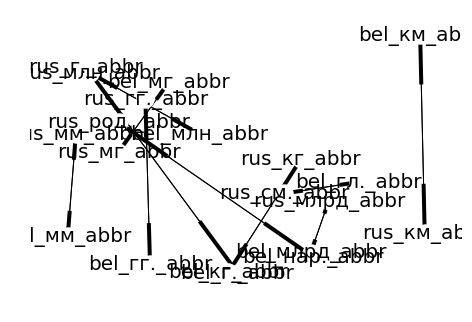

In [144]:
nx.draw_random(G, with_labels = True, font_size = 20, node_color = 'white')
plt.show()

In [16]:
G = nx.DiGraph()
logging.info('Start')
for T, l1, l2 in save_all(user):
    try:
        add_bidix(G, T, l1, l2)
    except:
        logging.info('not added {}-{}'.format(l1,l2))
    #add_bidix(G, T, l1, l2)
logging.info('Finish')

2018-05-17 21:42:56,474 | INFO : Start
2018-05-17 21:49:42,077 | INFO : not added lt-lv
b'<e r="LR"><par n="num-arabic" /><re>(,\\-| \\-| \\-\\-)?</re><par n="num-delimit" /><par n="num__det_qnt_pl" /></e>\n'
b'<e>       <par n="num-arabic" /><re>(,\\-| \\-| \\-\\-)?</re><par n="num__det_qnt_pl" /></e>\n \n'
b'<e r="LR"><par n="num-arabic" /><re> ?%</re><par n="num-delimit" /><par n="num__det_qnt_pl" /></e>\n'
b'<e>       <par n="num-arabic" /><re> ?%</re><par n="num__det_qnt_pl" /></e>\n\n \n'
b'<e>       <par n="num-arabic" /><par n="coll__n" /></e>\n \n\n \n'
b'<e r="LR"><par n="num-arabic" /><re>(,\\-| \\-| \\-\\-)?</re><par n="num-delimit" /><par n="num__det_qnt_pl" /></e>\n'
b'<e>       <par n="num-arabic" /><re>(,\\-| \\-| \\-\\-)?</re><par n="num__det_qnt_pl" /></e>\n \n'
b'<e r="LR"><par n="num-arabic" /><re> ?%</re><par n="num-delimit" /><par n="num__det_qnt_pl" /></e>\n'
b'<e>       <par n="num-arabic" /><re> ?%</re><par n="num__det_qnt_pl" /></e>\n\n \n'
b'<e>       <par n=

In [ ]:
import pickle as pkl
with open('graph.pkl','wb') as f:
    pkl.dump(G, f)